In [1]:
#run this if running IH

import os

# Force PyTorch to use legacy attention
os.environ["PYTORCH_ENABLE_FLASH_ATTENTION"] = "0"
os.environ["PYTORCH_ENABLE_SDPA"] = "0"
os.environ["PYTORCH_USE_RTSDP"] = "0"

In [2]:
#imports
import torch 
import transformers
from transformers import RobertaForSequenceClassification, RobertaTokenizerFast
import torch.nn.functional as F
import pandas as pd
from nltk.tree import Tree
from tqdm import tqdm
from copy import deepcopy

from io import BytesIO
from PIL import Image
from IPython.display import Image, display
import pydot


/home/hice1/zgoel3/.conda/envs/calculate_scores_gpu/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
#import a model
# Path to your model directory
model_path = "./roberta-base_sst"

# Set local_files_only=True so it doesn't try to fetch from Hugging Face Hub
tokenizer = RobertaTokenizerFast.from_pretrained(model_path, local_files_only=True)
model = RobertaForSequenceClassification.from_pretrained(model_path, local_files_only=True)
model = model.to(device)


# Load tokenizer and model
tokenizer = RobertaTokenizerFast.from_pretrained(model_path)
model = RobertaForSequenceClassification.from_pretrained(model_path)
model = model.to(device)






The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'RobertaTokenizerFast'.
You are using a model of type bert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ./roberta-base_sst and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.position_embeddings.weight', 'roberta.embeddings.token_type_embeddings.weight', 'roberta.embeddings.word_embeddings.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.l

In [5]:
#run this if doing integrated Hessians:

#  Add this right after model loading
from transformers.models.roberta.modeling_roberta import RobertaSelfAttention

def no_flash_attention_forward(self, hidden_states, attention_mask=None, head_mask=None, output_attentions=False):
    # legacy matmul attention logic
    mixed_query_layer = self.query(hidden_states)
    mixed_key_layer = self.key(hidden_states)
    mixed_value_layer = self.value(hidden_states)

    query_layer = self.transpose_for_scores(mixed_query_layer)
    key_layer = self.transpose_for_scores(mixed_key_layer)
    value_layer = self.transpose_for_scores(mixed_value_layer)

    attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
    attention_scores = attention_scores / math.sqrt(self.attention_head_size)

    if attention_mask is not None:
        attention_scores = attention_scores + attention_mask

    attention_probs = nn.Softmax(dim=-1)(attention_scores)
    attention_probs = self.dropout(attention_probs)

    context_layer = torch.matmul(attention_probs, value_layer)
    context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
    new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
    context_layer = context_layer.view(*new_context_layer_shape)

    outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)
    return outputs

RobertaSelfAttention.forward = no_flash_attention_forward


In [6]:

######################################### test if model import works

# Sample input
text = "I love this movie!"

# Tokenize input
inputs = tokenizer(text, return_tensors="pt")
if torch.cuda.is_available():
    inputs = {k: v.to(device) for k, v in inputs.items()}

# Get model predictions
with torch.no_grad():
    outputs = model(**inputs)

# Get probabilities (optional)

probs = F.softmax(outputs.logits, dim=-1)

# Print results
print("Logits:", outputs.logits)
print("Probabilities:", probs)

Logits: tensor([[0.3998, 0.4113]], device='cuda:0')
Probabilities: tensor([[0.4971, 0.5029]], device='cuda:0')


In [7]:
#import dataset amd parse the trees
# Load your dataset
df = pd.read_csv("sst_test_with_parsetrees.csv")

# Parse the parse tree column into NLTK Tree objects
df['parsed_tree'] = df['parse_tree'].apply(Tree.fromstring)

In [8]:


def tree_to_pydot(tree: Tree, parent_node=None, graph=None):
    """
    Recursively convert an NLTK Tree into a pydot graph.
    """
    if graph is None:
        graph = pydot.Dot(graph_type='graph')

    node_id = str(id(tree))
    label = tree.label() if isinstance(tree, Tree) else tree
    node = pydot.Node(node_id, label=label)
    graph.add_node(node)

    if parent_node:
        graph.add_edge(pydot.Edge(parent_node, node))

    if isinstance(tree, Tree):
        for child in tree:
            tree_to_pydot(child, node, graph)

    return graph


def draw_nice_parse_tree(parse_tree, output_path="parse_tree.png"):
    """
    Render a parse tree (as a Tree object or string) to an image.
    """
    if isinstance(parse_tree, str):
        tree = Tree.fromstring(parse_tree)
    elif isinstance(parse_tree, Tree):
        tree = parse_tree
    else:
        raise ValueError("parse_tree must be an NLTK Tree or a parse tree string.")

    graph = tree_to_pydot(tree)
    graph.write_png(output_path)
    display(Image(output_path))


In [9]:
# Utility: Get meaningful feature groups from the parse tree
def get_constituent_spans(tree, start=0):
    spans = []
    if isinstance(tree[0], str):  # Leaf node
        end = start + 1
        return [(tree.label(), start, end)], end
    else:
        curr_start = start
        for subtree in tree:
            subtree_spans, curr_start = get_constituent_spans(subtree, curr_start)
            spans.extend(subtree_spans)
        spans.append((tree.label(), start, curr_start))  # whole span
        return spans, curr_start

def span_to_token_indices(span_start, span_end, offset_mapping):
    """Map character span to token indices using offset mapping"""
    token_indices = []
    for i, (start, end) in enumerate(offset_mapping):
        if start >= span_end:
            break
        if end > span_start:
            token_indices.append(i)
    return token_indices


def annotate_parse_tree(parse_tree: Tree, v_scores: dict) -> Tree:
    """
    Annotate a copy of the parse tree with v(S) scores.

    Args:
        parse_tree (nltk.Tree): Original parse tree
        v_scores (dict): {(start_leaf_idx, end_leaf_idx): v(S) score}

    Returns:
        nltk.Tree: A new parse tree with labels annotated as "LABEL|score"
    """
    tree = deepcopy(parse_tree)

    def annotate_node(subtree, start_idx=0):
        if isinstance(subtree[0], str):
            span = (start_idx, start_idx + 1)
            score = v_scores.get(span, 0)
            subtree.set_label(f"{subtree.label()}|{score:.3f}")
            return start_idx + 1
        else:
            curr = start_idx
            for i in range(len(subtree)):
                curr = annotate_node(subtree[i], curr)
            span = (start_idx, curr)
            score = v_scores.get(span, 0)
            subtree.set_label(f"{subtree.label()}|{score:.3f}")
            return curr

    annotate_node(tree)
    return tree

def get_embeddings(model, inputs):
    return model.roberta.embeddings.word_embeddings(inputs['input_ids'])

In [ ]:
def compute_idg(text, parse_tree, m=50):
    # Tokenize input
    encoding = tokenizer(text, return_offsets_mapping=True, return_tensors='pt', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    offset_mapping = encoding['offset_mapping'][0].tolist()

    inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}

    # Baseline = [PAD] token IDs
    pad_token_id = tokenizer.pad_token_id
    baseline_ids = torch.full_like(input_ids, pad_token_id).to(device)
    baseline_inputs = {'input_ids': baseline_ids, 'attention_mask': attention_mask}

    # Compute interpolation steps
    alphas = torch.linspace(0, 1, steps=m+1).to(device)
    grads = []

    # Step 1: Get embeddings for input and baseline
    with torch.no_grad():
        input_embeds = get_embeddings(model, inputs)
        baseline_embeds = get_embeddings(model, baseline_inputs)

    # Step 2: Interpolate in embedding space and accumulate gradients
    for alpha in alphas:
        interp_embed = baseline_embeds + alpha * (input_embeds - baseline_embeds)
        interp_embed.requires_grad_()

        model.zero_grad()
        outputs = model(inputs_embeds=interp_embed, attention_mask=attention_mask)
        probs = F.softmax(outputs.logits, dim=-1)
        target_class = probs.argmax(dim=-1)

        output = outputs.logits[0, target_class]
        output.backward()
        grads.append(interp_embed.grad.detach().clone())

    avg_grad = torch.stack(grads).mean(dim=0).squeeze(0)  # shape: [seq_len, hidden_dim]

    # Extract constituent spans
    all_spans, _ = get_constituent_spans(parse_tree)
    idg_raw = {}

    for label, leaf_start, leaf_end in all_spans:
        leaf_text = " ".join(parse_tree.leaves()[leaf_start:leaf_end])
        start_char = text.find(leaf_text)
        if start_char == -1:
            continue
        end_char = start_char + len(leaf_text)

        token_idxs = span_to_token_indices(start_char, end_char, offset_mapping)
        if not token_idxs:
            continue

        z_s = torch.zeros_like(avg_grad)
        z_s[token_idxs] = input_embeds[0, token_idxs] - baseline_embeds[0, token_idxs]

        if torch.norm(z_s) == 0:
            continue
        z_hat = z_s / torch.norm(z_s)

        idg_val = torch.sum(avg_grad * z_hat).item()
        idg_raw[(leaf_start, leaf_end)] = idg_val

    # Normalize using absolute values
    abs_sum = sum(abs(v) for v in idg_raw.values()) + 1e-8
    d_scores = {span: abs(val) / abs_sum for span, val in idg_raw.items()}

    # Aggregate by parent span
    v_scores = {}
    for parent_span in idg_raw:
        p_start, p_end = parent_span
        v_scores[parent_span] = sum(
            d for (s, e), d in d_scores.items() if s >= p_start and e <= p_end
        )

    return v_scores


In [ ]:
#run inference on unmodified test set
#keep track of the predicted probabilites
#we will also calculate scores here because we need the gradients utilizing the parse trees

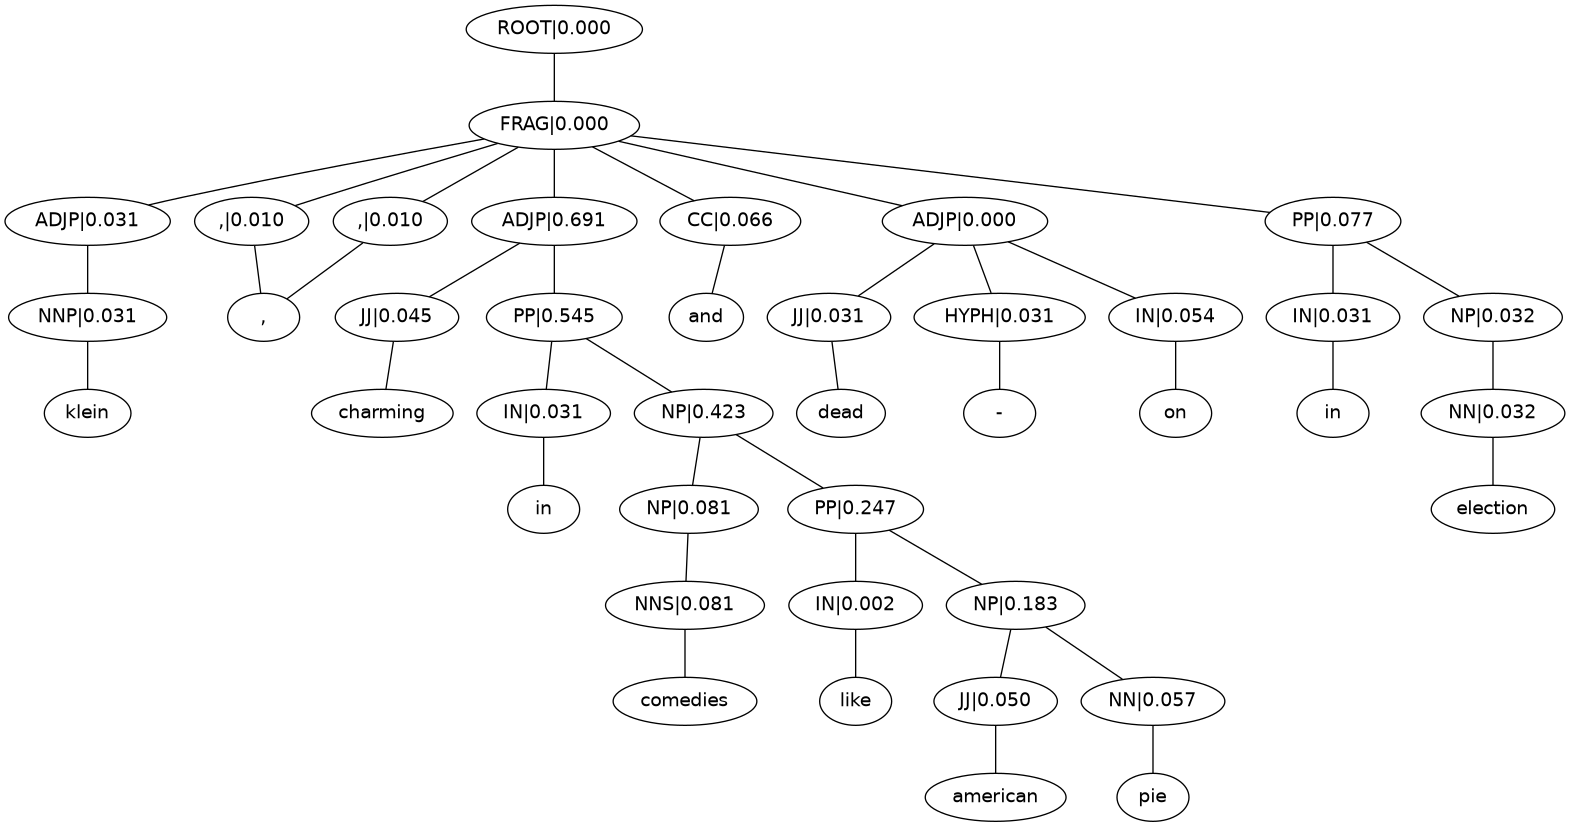

(ROOT|0.000
  (FRAG|0.000
    (ADJP|0.031 (NNP|0.031 klein))
    (,|0.010 ,)
    (ADJP|0.691
      (JJ|0.045 charming)
      (PP|0.545
        (IN|0.031 in)
        (NP|0.423
          (NP|0.081 (NNS|0.081 comedies))
          (PP|0.247 (IN|0.002 like) (NP|0.183 (JJ|0.050 american) (NN|0.057 pie))))))
    (CC|0.066 and)
    (ADJP|0.000 (JJ|0.031 dead) (HYPH|0.031 -) (IN|0.054 on))
    (PP|0.077 (IN|0.031 in) (NP|0.032 (NN|0.032 election)))
    (,|0.010 ,)))


In [31]:
text = "klein, charming in comedies like american pie and dead-on in election ,"
tree_str = "(ROOT (FRAG (ADJP (NNP klein)) (, ,) (ADJP (JJ charming) (PP (IN in) (NP (NP (NNS comedies)) (PP (IN like) (NP (JJ american) (NN pie)))))) (CC and) (ADJP (JJ dead) (HYPH -) (IN on)) (PP (IN in) (NP (NN election))) (, ,)))"
tree = Tree.fromstring(tree_str)

v_scores = compute_idg(text, tree, m=50)  # Get scores from IDG
annotated = annotate_parse_tree(tree, v_scores)  # Can reuse with other methods later


draw_nice_parse_tree(annotated, "beautiful_parse_tree.png")


print(annotated.pformat(margin=100))

In [10]:
from torch.autograd.functional import hessian

def interpolate_inputs(baseline, input_embed, steps=50):
    alphas = torch.linspace(0, 1, steps).to(input_embed.device)
    return torch.stack([baseline + alpha * (input_embed - baseline) for alpha in alphas])

def compute_integrated_hessian(input_embed, baseline_embed, model, inputs, target_class=None, steps=50):
    interpolated = interpolate_inputs(baseline_embed, input_embed, steps)
    integrated_hessian = torch.zeros_like(input_embed)

    for i in range(steps):
        def model_output_fn(embedding):
            embedding = embedding.unsqueeze(0)
            attention_mask = inputs['attention_mask']
            output = model(inputs_embeds=embedding, attention_mask=attention_mask)
            logit = output.logits[0]
            return logit[target_class] if target_class is not None else logit.max()

        hess = hessian(model_output_fn, interpolated[i])
        diag_hess = torch.diagonal(hess, dim1=-2, dim2=-1)
        integrated_hessian += diag_hess

    integrated_hessian /= steps
    squared_diff = (input_embed - baseline_embed) ** 2
    return squared_diff * integrated_hessian
def integrated_hessian_per_span(text, parse_tree_str, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", return_offsets_mapping=True, padding=True, truncation=True)
    offset_mapping = inputs.pop("offset_mapping")[0]  # shape: [seq_len, 2]
    inputs = {k: v.to(device) for k, v in inputs.items()}

    input_embed = get_embeddings(model, inputs)[0]
    baseline_inputs = tokenizer(" " * len(text), return_tensors="pt", padding="max_length", max_length=inputs['input_ids'].shape[1])
    baseline_inputs = {k: v.to(device) for k, v in baseline_inputs.items()}
    baseline_embed = get_embeddings(model, baseline_inputs)[0]

    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=-1)
        target_class = torch.argmax(probs).item()

    # Parse tree
    tree = Tree.fromstring(parse_tree_str)
    spans, _ = get_constituent_spans(tree)

    v_scores = {}

    for label, leaf_start, leaf_end in spans:
        # Map span in leaf index to character index, then to token index
        span_text = " ".join(tokenizer.convert_ids_to_tokens(inputs["input_ids"][0][leaf_start:leaf_end]))
        span_start_char = text.find(span_text.replace("Ġ", "").replace("▁", "").replace(" ", ""))
        span_end_char = span_start_char + len(span_text.replace("Ġ", "").replace("▁", "").replace(" ", ""))
        token_indices = span_to_token_indices(span_start_char, span_end_char, offset_mapping.tolist())

        if not token_indices:
            continue

        # Clone embeddings for the span
        modified_embed = baseline_embed.clone()
        modified_embed[token_indices] = input_embed[token_indices]

        ih = compute_integrated_hessian(modified_embed, baseline_embed, model, inputs, target_class=target_class)
        score = ih[token_indices].sum().item()
        v_scores[(leaf_start, leaf_end)] = score

    return v_scores

In [11]:
print("Using SDPA?", torch.backends.cuda.enable_flash_sdp)

Using SDPA? <function enable_flash_sdp at 0x1554668aa480>


In [13]:


print("Flash SDP enabled:", torch.backends.cuda.enable_flash_sdp())
print("Math SDP enabled:", torch.backends.cuda.enable_math_sdp())
print("Memory-Efficient SDP enabled:", torch.backends.cuda.enable_mem_efficient_sdp())


TypeError: enable_flash_sdp() missing 1 required positional argument: 'enabled'

In [15]:
text = "klein, charming in comedies like american pie and dead-on in election ,"
parse_tree_str = "(ROOT (FRAG (ADJP (NNP klein)) (, ,) (ADJP (JJ charming) (PP (IN in) (NP (NP (NNS comedies)) (PP (IN like) (NP (JJ american) (NN pie)))))) (CC and) (ADJP (JJ dead) (HYPH -) (IN on)) (PP (IN in) (NP (NN election))) (, ,)))"
tree = Tree.fromstring(parse_tree_str)

v_scores = integrated_hessian_per_span(text, parse_tree_str, model, tokenizer) # Get scores from IDG
annotated = annotate_parse_tree(tree, v_scores)  # Can reuse with other methods later


draw_nice_parse_tree(annotated, "beautiful_parse_tree.png")


print(annotated.pformat(margin=100))

RuntimeError: derivative for aten::_scaled_dot_product_efficient_attention_backward is not implemented

In [16]:
print("Flash SDP enabled:", torch.backends.cuda.flash_sdp_enabled)
print("Math SDP enabled:", torch.backends.cuda.math_sdp_enabled)
print("Memory-Efficient SDP enabled:", torch.backends.cuda.mem_efficient_sdp_enabled)


Flash SDP enabled: <function flash_sdp_enabled at 0x1554668aa3e0>
Math SDP enabled: <function math_sdp_enabled at 0x1554668aa660>
Memory-Efficient SDP enabled: <function mem_efficient_sdp_enabled at 0x1554668aa520>
